<a href="https://colab.research.google.com/github/psychoanalyzing-twitter/sentiment-analysis/blob/main/cw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task Distribution
| Member | ID | Tasks |
|---|---|---|
|Bhavika| bk2002 | Data Cleaning and Preprocessing, Logistic Regression, Visualization | 
|Alora| aat2000 | Data Labelling and Cleaning, FastText, Decision Trees and Conclusions |
|Andrea| acn2000 | Project Overview, Tweet Scraping, Text Representation |

# Project Pipeline

The following details the pipeline chosen for the project. A summary of the results are in the Conclusion section of this notebook.

## 1. Data Collection: 

Tweepy library will be used to scrape tweets from twitter. The tweets scraped must be related to Technology and innovation in the UAE.

## 2. Data Labelling: 

TextBlob and Vader are applied to the tweets for sentiment labelling and compared. The best fitting labeller is to be used in the next stages of the pipeline, which is chosen by means of manually inspecting the labels of the tweets.

## 3. Text Processing: 

Standard pre-processing techniques for NLP will be applied, such as removing numbers, removing stop words, etc. followed by tokenization. Lemmatization and stemming are compared, and the better technique will be used for the next stage.

## 4. Text Representation:

Various document representations are experimented with in this stage, which are bag of words, TF-IDF, CBOW, Skip-gram, and a pre-trained Google Word2Vec model.

Each of these representations are compared in terms of macro f1-score using a Naive Bayes classifier. Naive Bayes is used as it has been observed to be the most common classifier amongst several sentiment analysis projects, and that NB is "known to work well for many text classification problems and requires relatively few training examples" [1].

## 5. Classification

The chosen document representation will be used as input for the following classifiers: Logistic regression, decision trees, and FastText (a sentiment analysis classifier by Facebook).

## 6. Evaluation

Evaluation of the models is conducted, using precision, recall, and f1 score are the main metrics. These metrics are chosen due to the class imbalance, where metrics such as accuracy or AUROC do not provide meaningful insights [2]


Sources:

[1] https://www.aiperspectives.com/twitter-sentiment-analysis/ <br>
[2] https://glassboxmedicine.com/2019/03/02/measuring-performance-auprc/ <br>



# Import Libraries

In [4]:
%pip install tweepy


Note: you may need to restart the kernel to use updated packages.


In [5]:
# common modules
import tweepy
import csv
import pandas as pd
import re
import numpy as np

# for text labelling
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# for data cleaning/preprocessing
from sklearn.feature_extraction import text
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer

# for representation/classification
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support

# representation
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
import gensim

# classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import fasttext

# for visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter


# Scraping Tweets

In [6]:
# Keys for authentication
consumer_key = "ONLQ0vLSAXM2tZDnckominEcK"
consumer_secret = "MpP7XurdGn1wpufX3rrfQgrs4AROnaw9ZiiZzKN6exr3zEDlN6"
access_token = "1274112117738737664-J2DjjoqqzN11CNp8bpnYzVp1dUYKM4"
access_token_secret = "3coYFJVCqHnOmD2m9Qt6zs7j1I24lhlPTU71eUOq4Zqg9"
bearer_token = "AAAAAAAAAAAAAAAAAAAAALJslQEAAAAA7EWdkTwrVDM44LIuewNascHjvoY%3DeXmhQyuXgo8zXJiSTMfqtmPA393HHO2W7nSrk0bK6b67SuJeb0"


In [7]:
# Authenticate
auth = tweepy.OAuth1UserHandler(
    consumer_key, consumer_secret, access_token, access_token_secret)

api = tweepy.API(auth)


In [8]:
def scrape_tweets(query: str, amount: int) -> list:
    """Scrapes a specified number of tweets based on given query and location.

    Based on https://www.sahilfruitwala.com/guide-to-extract-tweets-using-tweepy#how-to-retrieve-specific-number-of-tweets-using-tweepy 

    Args:
        query (str): The query
        amount (int): Number of tweets to scrape
    Returns:
        list (str): List of contents of tweets.
    """
    extracted_tweets = []
    for tweet in tweepy.Cursor(api.search_tweets, query, count=100, tweet_mode="extended", result_type="recent").items(amount):
        extracted_tweets.append(tweet.full_text)
    return extracted_tweets


In [9]:
def write_to_csv(tweets: list, csv_name: str) -> None:
    """Appends the list of tweets to csv.

    Based on https://gist.github.com/anku255/0cebd75cce675f2b56de1ef48ec06575.

    Args:
        tweets (list): List of tweets (type str)
        csv_name (str): Name of CSV to write to

    """
    print("Writing {0} tweets to {1}".format(len(tweets), csv_name))
    tweets_for_csv = [[tweet.encode("utf-8")] for tweet in tweets]
    with open(csv_name, "a+") as file:
        writer = csv.writer(file, delimiter=",")
        writer.writerows(tweets_for_csv)


In [10]:
# The queries for scraping tweets.

queries = [
    ["(metaverse OR meta verse OR #metaverse OR #meta #verse) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(innovation OR #innovation OR innovate OR innovative OR #innovate OR #innovative) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(sustainability OR #sustainability OR sustainable) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(technology footprint OR technology OR #technologyfootprint) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(artificial intelligence OR ai OR #ai OR #artificialintelligence) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(ethics OR #ethics OR ethical OR #ethical) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(inflation OR #inflation) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(cop 28 OR cop28 OR #cop28 OR #cop #28) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(museum of the future OR @museumofthefuture OR #museumofthefuture OR #museum #of #the #future) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(bit coin OR bitcoin OR #bitcoin OR #crypto OR crpyto OR cryptocurrency) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(cyber attack OR #cyberattack OR #cyber OR #cyberattacks OR #cyber #attack) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(robot OR robots OR #robots OR #robot) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(drone OR drones OR #drone OR #drones) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(hacker OR hacking OR #hacker OR #hacking OR #hack) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(chatgpt OR #chatgpt OR #chat #gpt OR chat gpt) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(cybersecurity OR #cybersecurityOR #cybersec OR cybersec OR cyber security OR #cyber #security) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(sustainabletech OR sustainable ai OR sustainable technology OR #sustainabletech OR #sustainableai OR #sustainabletechnology) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(computing OR quantum computing OR #quantum #computing OR #computing) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(automation OR #automation) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(distributed cloud OR #distributedcloud OR #distributed #cloud) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(big data OR #big #data OR bigdata OR #bigdata) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(ar OR #ar OR #augmentedreality OR #augmented #reality) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(data mining OR #data #mining OR #datamining) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(software OR #software) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(tech OR technology OR #tech OR #technology) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(digital OR digital transformation OR #digital #transformation OR #digitaltransformation) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(blockchain OR #blockchain) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(coders_hq OR coders hq OR #coders OR #coders #hq OR @coders_hq) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(nft OR non-fungible token OR non fungible token OR nfts OR #nfts OR #nonfungibletoken OR #nft) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(binance OR @binance OR #binance) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(uae hackathon OR hackathon OR #hackathon) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(internet of things OR IoT OR #iot OR #internet #of #things OR #internetofthings) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(software engineering OR #softwareengineering) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(#coding OR coding) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(@uaeai OR #uaeai Or #uae #ai) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(technology OR tech OT #tech Or #technology) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(nft OR #nft OR #nfts OR nfts) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(UAE codes OR #UAE_codes OR #UAEcodes) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(Microsoft Hololens OR Hololens OR #Hololens) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(GITEX or #gitex) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(information OR #information) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(internet OR #internet) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(computer OR science OR computer science OR #computerscience OR #computer OR #science) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(technological OR #technological) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(engineering OR #engineering) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(computing OR #computing) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(systems OR #systems) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(electronics OR #electronics) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(application OR #application OR app OR #app) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(robotics OR #robotics) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(high tech OR high technology OR #hightech OR #hightechnology OR #high #technology OR #high #tech) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(nanotech OR nano tech OR nanotechnology OR nano technology OR #nanotech OR #nano #tech OR #nano #technology OR #nanotechnology) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(biotech OR bio tech OR biotechnology OR bio technology OR #biotech OR #bio #tech OR #bio #technology OR #biotechnology) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(code OR #code) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(automation OR #automation OR automate OR #automate) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(virtual OR #virtual OR online OR #online) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(technological advancements OR #technological #advancements OR #advancements OR #techadvancements) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(bionics OR #bionics) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(cyberscience OR #cyberscience) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(google OR #google OR @google) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(oracle OR #oracle OR @oracle) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(ibm OR #ibm OR @ibm) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(bionics OR #bionics) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(sap OR #sap) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(global knowledge OR #globalknowledge OR #global #knowledge) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(amazon OR #amazon OR @amazon) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(hewlett-packard OR Hewlett Packard OR HP OR #hewlett-packard OR #Hewlett #Packard OR #HP) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(cisco OR #cisco OR @cisco) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(dell OR #dell OR @dell) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(cisco OR #cisco OR @cisco) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(@WorldGovSummit OR #WGS OR #WGS2023 OR World Goverment Summit) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(masdar OR #masdar OR @masdar) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(renewable energy OR clean energy OR #renewableenergy OR #cleanenergy) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(machine learning OR #machinelearning OR ML OR #ML) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(recommender systems OR #RS OR #recommender #systems OR recommender engine) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(deep learning OR #deeplearning) AND (place_country:AE OR uae) lang:en -filter:retweets"],
    ["(research OR #research) AND (place_country:AE OR uae) lang:en -filter:retweets"],
]


Getting the tweets using the queries

In [11]:
# """Scraping tweets and writing them to dataset.csv"""
# csv_name="dataset.csv"
# total = 0
# for query in queries:
#     tweets = scrape_tweets(query=query, amount=500)
#     total += len(tweets)
#     print("Found {0} tweets related to the query {1}".format(len(tweets), query))
#     write_to_csv(tweets=tweets,csv_name=csv_name)
# print("Done. {0} rows.".format(total))


# Data Cleaning

This section cleans the scraped tweets dataset of duplicate tweets, URLs, @'s and #s.

In [12]:
# Dropping duplicates
dataset = pd.read_csv("dataset.csv", header=None)
dataset.rename(columns={0: 'Text'}, inplace=True)


In [13]:
dataset

,Text
0,b'Joined UAE Minister &amp; President-Designat...
1,b'Foreign Secretary @AmbVMKwatra participated ...
2,"b'As the UAE marks National Environment Day, w..."
3,b'RT @KhalifaAlgaz: Did you know that the UAE ...
4,b'RT @tawhidChtioui: \xf0\x9f\x9b\xb0\xef\xb8\...
...,...
21974,b'Send our special gifts to your loved ones!\x...
21975,b'Trainer code: 2735 9457 4031\nfrom \xf0\x9f\...
21976,"b""We are looking for ICY SNOW , SANDSTORM .\nI..."
21977,b'Make #MONEY from #home through PC #APP \nMak...


In [14]:
updated_dataset = dataset.drop_duplicates().copy()
updated_dataset

,Text
0,b'Joined UAE Minister &amp; President-Designat...
1,b'Foreign Secretary @AmbVMKwatra participated ...
2,"b'As the UAE marks National Environment Day, w..."
3,b'RT @KhalifaAlgaz: Did you know that the UAE ...
4,b'RT @tawhidChtioui: \xf0\x9f\x9b\xb0\xef\xb8\...
...,...
21888,b'@m_ut67 @modgovae @Forsan_UAE Dear sir pleas...
21889,b'@UAE_BARQ Dear sir please my help you sir my...
21890,b'@UAE_BARQ Dear sir please my help you sir my...
21915,"b""#PhonePe launched a service on Tuesday that ..."


### Removing URLs, @'s and hashtags

In [15]:
tweets = updated_dataset['Text'].copy()
updated_dataset['Cleaned Text'] = tweets.str.replace(
    r'@[^\s]+|#[^\s]+|https?:\/\/\S+|www\.\S+', '', regex=True)
updated_dataset['Cleaned Text'].head()


0    b'Joined UAE Minister &amp; President-Designat...
1    b'Foreign Secretary  participated in a meeting...
2    b'As the UAE marks National Environment Day, w...
3    b'RT  Did you know that the UAE is developing ...
4    b'RT  \xf0\x9f\x9b\xb0\xef\xb8\x8f UAE lunar r...
Name: Cleaned Text, dtype: object

### Removing Duplicates again

In [16]:
#updated_dataset = updated_dataset.drop('Text', axis=1)
updated_dataset = updated_dataset.drop_duplicates()
updated_dataset.shape


(5878, 2)

In [17]:
updated_dataset.to_csv('updated-dataset.csv')


In [18]:
updated_dataset = pd.read_csv('updated-dataset.csv', index_col=0)
updated_dataset


,Text,Cleaned Text
0,b'Joined UAE Minister &amp; President-Designat...,b'Joined UAE Minister &amp; President-Designat...
1,b'Foreign Secretary @AmbVMKwatra participated ...,b'Foreign Secretary participated in a meeting...
2,"b'As the UAE marks National Environment Day, w...","b'As the UAE marks National Environment Day, w..."
3,b'RT @KhalifaAlgaz: Did you know that the UAE ...,b'RT Did you know that the UAE is developing ...
4,b'RT @tawhidChtioui: \xf0\x9f\x9b\xb0\xef\xb8\...,b'RT \xf0\x9f\x9b\xb0\xef\xb8\x8f UAE lunar r...
...,...,...
21888,b'@m_ut67 @modgovae @Forsan_UAE Dear sir pleas...,b' Dear sir please my help you sir my two ki...
21889,b'@UAE_BARQ Dear sir please my help you sir my...,b' Dear sir please my help you sir my two kidn...
21890,b'@UAE_BARQ Dear sir please my help you sir my...,b' Dear sir please my help you sir my two kidn...
21915,"b""#PhonePe launched a service on Tuesday that ...","b"" launched a service on Tuesday that will all..."


# Data Labelling


### TextBlob

For data labelling, we decided to use first use TextBlob. TextBlob calculates the subjectivity and polarity of a text to classify the text as 'Positive', 'Negative' or 'Neutral'

In [19]:
# %pip install TextBlob

In [20]:
# Function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity


# Function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity


# Create two new columns ‘Subjectivity’ & ‘Polarity’
updated_dataset['TextBlob Subjectivity'] = updated_dataset['Cleaned Text'].apply(
    getSubjectivity)
updated_dataset['TextBlob Polarity'] = updated_dataset['Cleaned Text'].apply(
    getPolarity)


def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'


updated_dataset['TextBlob Sentiment'] = updated_dataset['TextBlob Polarity'].apply(
    getAnalysis)


In [21]:
updated_dataset['TextBlob Sentiment'].value_counts()


Positive    2783
Neutral     2576
Negative     519
Name: TextBlob Sentiment, dtype: int64

It can be observed that TextBlob classified the majority of tweets to be Positive. To compare, we also decided to use Vader as well to observe if there was a major difference in classification.

### Vader

In [22]:
# %pip install vaderSentiment


In [23]:
sentiment = SentimentIntensityAnalyzer()


def getSentiment(text):
    return sentiment.polarity_scores(text)


updated_dataset['Vader Analysis'] = updated_dataset['Cleaned Text'].apply(
    getSentiment)


def sentimentAnalysis(sentiment_dict):
    if sentiment_dict['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_dict['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'


updated_dataset['Vader Sentiment'] = updated_dataset['Vader Analysis'].apply(
    sentimentAnalysis)


In [24]:
updated_dataset[['Vader Analysis', 'Vader Sentiment']]


,Vader Analysis,Vader Sentiment
0,"{'neg': 0.0, 'neu': 0.638, 'pos': 0.362, 'comp...",Positive
1,"{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'comp...",Positive
2,"{'neg': 0.0, 'neu': 0.766, 'pos': 0.234, 'comp...",Positive
3,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",Positive
4,"{'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'comp...",Positive
...,...,...
21888,"{'neg': 0.073, 'neu': 0.726, 'pos': 0.202, 'co...",Positive
21889,"{'neg': 0.073, 'neu': 0.726, 'pos': 0.202, 'co...",Positive
21890,"{'neg': 0.074, 'neu': 0.719, 'pos': 0.206, 'co...",Positive
21915,"{'neg': 0.043, 'neu': 0.774, 'pos': 0.183, 'co...",Positive


In [25]:
updated_dataset['Vader Sentiment'].value_counts()


Positive    3604
Neutral     1890
Negative     384
Name: Vader Sentiment, dtype: int64

## Analysis between Vader and TextBlob


| Data Labelling Method      | Positive Label | Negative Label | Neutral Label |
| ----------- | ----------- | ----------- | ----------- |
| TextBlob      | 2643   (49%)   |479  (8.9%)| 2276 (42.1%)|
| Vader   | 3335  (61.8%)      | 372 (6.9%) | 1691 (31.3%)|

From the summary table, we can observe that the negatively labelled tweets stay within a 2% difference of each other, regardless of the data labelling method. However, the positive and neutral label differ by 10%.

In [26]:
# Creating a csv of tweets with conflicting sentiments
unclearTweets = updated_dataset.loc[(
    updated_dataset['Vader Sentiment'] != updated_dataset['TextBlob Sentiment'])]
unclearTweets.to_csv('ConflictingLabels.csv')


In [27]:
unclearTweets


,Text,Cleaned Text,TextBlob Subjectivity,TextBlob Polarity,TextBlob Sentiment,Vader Analysis,Vader Sentiment
1,b'Foreign Secretary @AmbVMKwatra participated ...,b'Foreign Secretary participated in a meeting...,0.562500,-0.062500,Negative,"{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'comp...",Positive
3,b'RT @KhalifaAlgaz: Did you know that the UAE ...,b'RT Did you know that the UAE is developing ...,0.000000,0.000000,Neutral,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",Positive
4,b'RT @tawhidChtioui: \xf0\x9f\x9b\xb0\xef\xb8\...,b'RT \xf0\x9f\x9b\xb0\xef\xb8\x8f UAE lunar r...,1.000000,-0.600000,Negative,"{'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'comp...",Positive
10,b'RT @GrapheneCouncil: UK BUSINESS SECRETARY P...,b'RT UK BUSINESS SECRETARY PRAISES UK-UAE GRA...,0.000000,0.000000,Neutral,"{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'comp...",Positive
14,"b'RT @UAE_Forsan: As host of COP28, UAE is com...","b'RT As host of COP28, UAE is committed to le...",0.125000,0.000000,Neutral,"{'neg': 0.0, 'neu': 0.817, 'pos': 0.183, 'comp...",Positive
...,...,...,...,...,...,...,...
21888,b'@m_ut67 @modgovae @Forsan_UAE Dear sir pleas...,b' Dear sir please my help you sir my two ki...,0.100000,0.000000,Neutral,"{'neg': 0.073, 'neu': 0.726, 'pos': 0.202, 'co...",Positive
21889,b'@UAE_BARQ Dear sir please my help you sir my...,b' Dear sir please my help you sir my two kidn...,0.100000,0.000000,Neutral,"{'neg': 0.073, 'neu': 0.726, 'pos': 0.202, 'co...",Positive
21890,b'@UAE_BARQ Dear sir please my help you sir my...,b' Dear sir please my help you sir my two kidn...,0.100000,0.000000,Neutral,"{'neg': 0.074, 'neu': 0.719, 'pos': 0.206, 'co...",Positive
21915,"b""#PhonePe launched a service on Tuesday that ...","b"" launched a service on Tuesday that will all...",0.062500,-0.062500,Negative,"{'neg': 0.043, 'neu': 0.774, 'pos': 0.183, 'co...",Positive


After manually reviewing the differences in labels, it seems that the TextBlob sentiment labelling is more accurate.

# Data Preprocessing

## Additional Data Cleaning

### Removing Non-English Characters

In [28]:
def nonenglish(tweet):
    # tweets in different language changed to hex code \xhh
    tweet = re.sub(r'\\x[a-zA-Z0-9]+', '', tweet)
    tweet = re.sub(r'\\n', '', tweet)  # removing new line character as well
    return tweet


updated_dataset['Cleaned Text'] = updated_dataset['Cleaned Text'].apply(
    lambda tweet: nonenglish(tweet).lower())
updated_dataset['Cleaned Text'].head()


0    b'joined uae minister &amp; president-designat...
1    b'foreign secretary  participated in a meeting...
2    b'as the uae marks national environment day, w...
3    b'rt  did you know that the uae is developing ...
4    b'rt   uae lunar rover will test 1st artificia...
Name: Cleaned Text, dtype: object

### Removing Stopwords

In [29]:
# contains 318 stopwords, including but not limited to articles and prepositions
stopwords = text.ENGLISH_STOP_WORDS
updated_dataset['Cleaned Text'] = updated_dataset['Cleaned Text'].apply(
    lambda tweet: ' '.join([text for text in tweet.split(' ') if text not in stopwords]))
updated_dataset['Cleaned Text'].head()


0    b'joined uae minister &amp; president-designat...
1    b'foreign secretary  participated meeting foca...
2    b'as uae marks national environment day, remai...
3    b'rt  did know uae developing arabic chatgpt u...
4    b'rt   uae lunar rover test 1st artificial int...
Name: Cleaned Text, dtype: object

### Removing Symbols and Punctuations

In [30]:
punctuations = string.punctuation
print(punctuations)

updated_dataset['Cleaned Text'] = updated_dataset['Cleaned Text'].apply(
    lambda tweet: tweet.translate({ord(punc): None for punc in punctuations}))
updated_dataset['Cleaned Text'].head()


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


0    bjoined uae minister amp presidentdesignate  d...
1    bforeign secretary  participated meeting focal...
2    bas uae marks national environment day remain ...
3    brt  did know uae developing arabic chatgpt us...
4    brt   uae lunar rover test 1st artificial inte...
Name: Cleaned Text, dtype: object

### Removing Numbers

In [31]:
updated_dataset['Cleaned Text'] = updated_dataset['Cleaned Text'].apply(
    lambda tweet: re.sub('[0-9]+', '', tweet))
updated_dataset['Cleaned Text'].head()


0    bjoined uae minister amp presidentdesignate  d...
1    bforeign secretary  participated meeting focal...
2    bas uae marks national environment day remain ...
3    brt  did know uae developing arabic chatgpt us...
4    brt   uae lunar rover test st artificial intel...
Name: Cleaned Text, dtype: object

### Removing 'b' and 'rt'

In [32]:
def removeb(tweet):
    if tweet[:3] == 'brt':
        return tweet[3:]
    else:
        return tweet[1:]
updated_dataset['Cleaned Text'] = updated_dataset['Cleaned Text'].apply(
    lambda tweet: removeb(tweet))
updated_dataset['Cleaned Text'].head()


0    joined uae minister amp presidentdesignate  dr...
1    foreign secretary  participated meeting focal ...
2    as uae marks national environment day remain c...
3      did know uae developing arabic chatgpt using...
4       uae lunar rover test st artificial intellig...
Name: Cleaned Text, dtype: object

### Tokenization

In [33]:
# as data has been completely cleaned, we can simply tokenize by converting strings to lists
updated_dataset['Tokenized Text'] = updated_dataset['Cleaned Text'].apply(
    lambda tweet: tweet.split())
updated_dataset['Tokenized Text'].head()


0    [joined, uae, minister, amp, presidentdesignat...
1    [foreign, secretary, participated, meeting, fo...
2    [as, uae, marks, national, environment, day, r...
3    [did, know, uae, developing, arabic, chatgpt, ...
4    [uae, lunar, rover, test, st, artificial, inte...
Name: Tokenized Text, dtype: object

### Lemmatization

In [34]:
lemmatizing = WordNetLemmatizer()

updated_dataset['Lemmatized Text'] = updated_dataset['Tokenized Text'].apply(
    lambda tweet: [lemmatizing.lemmatize(text) for text in tweet])
updated_dataset['Lemmatized Text'].head()


0    [joined, uae, minister, amp, presidentdesignat...
1    [foreign, secretary, participated, meeting, fo...
2    [a, uae, mark, national, environment, day, rem...
3    [did, know, uae, developing, arabic, chatgpt, ...
4    [uae, lunar, rover, test, st, artificial, inte...
Name: Lemmatized Text, dtype: object

### Stemming

In [35]:
stem = PorterStemmer()
updated_dataset['Stemmed Text'] = updated_dataset['Tokenized Text'].apply(
    lambda tweet: [stem.stem(text) for text in tweet])
updated_dataset['Stemmed Text'].head()

0    [join, uae, minist, amp, presidentdesign, dr, ...
1    [foreign, secretari, particip, meet, focal, po...
2    [as, uae, mark, nation, environ, day, remain, ...
3    [did, know, uae, develop, arab, chatgpt, use, ...
4    [uae, lunar, rover, test, st, artifici, intell...
Name: Stemmed Text, dtype: object

### Comparing Lemmatization and Stemming

In [36]:
# Encode TextBlob adn Vader Sentiments into numbers
updated_dataset['Encoded_TextBlob_Sentiment'] = updated_dataset['TextBlob Sentiment'].apply(
    lambda x: 1 if x == 'Positive' else -1 if x == 'Negative' else 0)

updated_dataset['Encoded_Vader_Sentiment'] = updated_dataset['Vader Sentiment'].apply(
    lambda x: 1 if x == 'Positive' else -1 if x == 'Negative' else 0)

# resets the index numbers of the dataframe
updated_dataset.reset_index(inplace=True, drop=True)

In [37]:
# splitting into train/test to compare lemma and stem
X1 = updated_dataset['Lemmatized Text']
X2 = updated_dataset['Stemmed Text']

y = updated_dataset['Encoded_Vader_Sentiment']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=47, stratify=updated_dataset['Encoded_Vader_Sentiment'])
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=47, stratify=updated_dataset['Encoded_Vader_Sentiment'])

In [38]:
bow = CountVectorizer(
    ngram_range=(1, 1),  # unigram
    preprocessor=lambda x: x,  # override preprocessing cause already done
    tokenizer=lambda x: x,  # override tokenization cause already done
)

nb_bow = Pipeline([
    ('bow', bow),
    ('logistic_regression', LogisticRegression())
])

# first lemma
nb_bow.fit(X1_train, y1_train)
y1_pred_bow = nb_bow.predict(X1_test)
print("Classification using Lemmatized text:")
print(classification_report(y1_test, y1_pred_bow))

# stemming
nb_bow.fit(X2_train, y2_train)
y2_pred_bow = nb_bow.predict(X2_test)
print("\nClassification using Stemmed text:")
print(classification_report(y2_test, y2_pred_bow))

Classification using Lemmatized text:
              precision    recall  f1-score   support

          -1       0.81      0.38      0.51        77
           0       0.78      0.82      0.80       378
           1       0.88      0.91      0.90       721

    accuracy                           0.85      1176
   macro avg       0.82      0.70      0.74      1176
weighted avg       0.85      0.85      0.84      1176


Classification using Stemmed text:
              precision    recall  f1-score   support

          -1       0.70      0.34      0.46        77
           0       0.81      0.83      0.82       378
           1       0.88      0.92      0.90       721

    accuracy                           0.85      1176
   macro avg       0.80      0.70      0.73      1176
weighted avg       0.85      0.85      0.85      1176



Lemmatization and Stemming, when compared with each other using Bag of Words text representation and Logistic Regression classifier seem to give the exact same accuracy. The only notable difference here is the f1-score of class -1 (negative) where lemmatized text gives 5% more than stemmed text. 
 
In general, stemming is a process that removes last few letters of a word to bring it to its original or "stemmed" form. Lemmatization converts the word into its base form keeping the context in mind. Stemming can sometimes resilt in incorrect interpretations of the words as well as give the wrong spellings. Overall, lemmatization has been known to have a higher accuracy than stemming [1], which is why we will continue to use lemmatization throughout the rest of the notebook.

Source:
[1] https://analyticsindiamag.com/explained-stemming-vs-lemmatization-in-nlp/

# Text Representation

This section experiments with different document representations, namely:
- Bag of Words
- N-grams
- TF-IDF
- CBOW
- Skip-gram
- Pre-trained Word2Vec model by Google


Each of the representations are tested using Naive Bayes, and the high performance models are used in the next stage of the pipeline.


Getting train and test sets ready

In [39]:
X = updated_dataset['Lemmatized Text']
y = updated_dataset['Encoded_Vader_Sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=updated_dataset['Encoded_Vader_Sentiment']
)


## Bag Of Words

In [40]:

bow = CountVectorizer(
    ngram_range=(1, 1),  # unigram
    preprocessor=lambda x: x,  # override preprocessing cause already done
    tokenizer=lambda x: x,  # override tokenization cause already done
)

nb_bow = Pipeline([
    ('bow', bow),
    ('naive_bayes', MultinomialNB())
])

nb_bow.fit(X_train, y_train)
y_pred_bow = nb_bow.predict(X_test)
print(classification_report(y_test, y_pred_bow))


              precision    recall  f1-score   support

          -1       0.68      0.34      0.45        77
           0       0.79      0.54      0.64       378
           1       0.77      0.94      0.84       721

    accuracy                           0.77      1176
   macro avg       0.75      0.60      0.65      1176
weighted avg       0.77      0.77      0.75      1176



## N-grams
The n-grams tested are $(a,b)$, which denotes a vector representation where a-grams up until b-grams are used.
E.g. When the n-gram range is (1,3), the vector representation of the document includes unigrams, bigrams, and trigrams. 

If the range is $(a,a)$, only a-grams are used. E.g. (1,1) denotes unigrams.

Possible n-gram values that are tested are:
$\text{n-gram values}=\{(a,b) | a \in \{1,2,...,9\} \cap b \in \{1,2,...,9\} \cap (a <= b)\}$

It is observed that the n-gram range (1,6) provides the best macro-f1 score.

In [41]:
A = np.arange(1, 10)
B = np.arange(1, 10)

# Generate possible n-gram pairs
ngram_pairs = [(a, b) for a in A for b in B if a <= b]

results_ngram = {}
for ngram_range in ngram_pairs:
    ngram = CountVectorizer(
        ngram_range=ngram_range,
        preprocessor=lambda x: x,  # override preprocessing
        tokenizer=lambda x: x,  # override tokenization
    )

    ngram_nb = Pipeline([
        ('ngram', ngram),
        ('naive_bayes', MultinomialNB())
    ])

    ngram_nb.fit(X_train, y_train)
    ngram_nb_y_pred = ngram_nb.predict(X_test)

    prec, recall, f1, support = precision_recall_fscore_support(
        y_test, ngram_nb_y_pred, beta=1.0, average='macro')
    results_ngram[ngram_range] = {
        'precision': prec, 'recall': recall, 'f1-score': f1}


In [42]:
ngram_results = pd.DataFrame.from_dict(results_ngram, orient='index', columns=[
                                       'precision', 'recall', 'f1-score'])
ngram_results.index.names = ['min_ngram', 'max_ngram']
# get n-grams corresponding to max f1 score
ngram_results.idxmax()


precision    (1, 6)
recall       (2, 4)
f1-score     (1, 6)
dtype: object

In [43]:
ngram_results


precision    recall  f1-score
min_ngram max_ngram                               
1         1           0.747873  0.604095  0.645324
          2           0.844544  0.602070  0.654755
          3           0.863498  0.611653  0.668150
          4           0.863751  0.618085  0.676132
          5           0.852666  0.618504  0.675190
          6           0.865024  0.618547  0.676731
          7           0.862897  0.613336  0.670629
          8           0.862897  0.613336  0.670629
          9           0.862897  0.613336  0.670629
2         2           0.775045  0.612072  0.658060
          3           0.773949  0.619089  0.664463
          4           0.775086  0.620853  0.666171
          5           0.779753  0.616104  0.662356
          6           0.779753  0.616104  0.662356
          7           0.779753  0.616104  0.662356
          8           0.779753  0.616104  0.662356
          9           0.780320  0.616986  0.663208
3         3           0.823087  0.565367  0.616928
          4           0.823304  0.567550  0.619233
          5           0.823304  0.567550  0.619233
          6           0.822769  0.566668  0.618277
          7           0.823304  0.567550  0.619233
          8           0.821937  0.567088  0.618662
          9           0.823837  0.568432  0.620186
4         4           0.822116  0.556172  0.607037
          5           0.821692  0.557473  0.608462
          6           0.820752  0.557893  0.608887
          7           0.820752  0.557893  0.608887
          8           0.821294  0.558775  0.609873
          9           0.821835  0.559657  0.610857
5         5           0.827691  0.535174  0.583370
          6           0.825993  0.534711  0.582826
          7           0.827691  0.535174  0.583370
          8           0.831112  0.538282  0.587088
          9           0.831112  0.538282  0.587088
6         6           0.830506  0.525602  0.571379
          7           0.831662  0.527366  0.573601
          8           0.832234  0.528247  0.574707
          9           0.832234  0.528247  0.574707
7         7           0.817609  0.493375  0.529046
          8           0.818874  0.495139  0.531351
          9           0.819711  0.493837  0.529563
8         8           0.812262  0.465143  0.488561
          9           0.812262  0.465143  0.488561
9         9           0.791375  0.435826  0.444417

## TF-IDF

The TF-IDF vectorizor is tested over several n-gram ranges. The ranges are: $\text{n-gram values}=\{(a,b) | a \in \{1,2,...,9\} \cap b \in \{1,2,...,9\} \cap (a <= b)\}$.

It is observed that the tfidf vector with n-gram range (2,2) provides the best macro-f1 score.

In [44]:
A = np.arange(1, 10)
B = np.arange(1, 10)

# Generate possible n-gram pairs
ngram_pairs = [(a, b) for a in A for b in B if a <= b]

results_tfidf = {}
for ngram_range in ngram_pairs:
    tfidf = TfidfVectorizer(
        preprocessor=lambda x: x,  # override preprocessing
        tokenizer=lambda x: x,  # override tokenization
        ngram_range=ngram_range
    )

    tfidf_nb = Pipeline([
        ('tfidf', tfidf),
        ('naive_bayes', MultinomialNB())
    ])

    tfidf_nb.fit(X_train, y_train)
    tfidf_nb_y_pred = tfidf_nb.predict(X_test)
    prec, recall, f1, support = precision_recall_fscore_support(
        y_test, tfidf_nb_y_pred, beta=1.0, average='macro')
    results_tfidf[ngram_range] = {
        'precision': prec, 'recall': recall, 'f1-score': f1}


In [45]:
tfidf_results = pd.DataFrame.from_dict(results_tfidf, orient='index', columns=[
                                       'precision', 'recall', 'f1-score'])
tfidf_results.index.names = ['min_ngram', 'max_ngram']
# get n-grams corresponding to max f1 score
tfidf_results.idxmax()


precision    (1, 2)
recall       (2, 2)
f1-score     (2, 2)
dtype: object

In [46]:
tfidf_results


precision    recall  f1-score
min_ngram max_ngram                               
1         1           0.879702  0.451216  0.454846
          2           0.884412  0.470111  0.479256
          3           0.881558  0.477962  0.488796
          4           0.883403  0.490227  0.505911
          5           0.881891  0.490647  0.506337
          6           0.878209  0.489722  0.505172
          7           0.874604  0.488798  0.504010
          8           0.874604  0.488798  0.504010
          9           0.874604  0.488798  0.504010
2         2           0.863371  0.496982  0.512138
          3           0.863625  0.495219  0.510403
          4           0.863281  0.494756  0.510009
          5           0.865589  0.494337  0.509812
          6           0.863114  0.492111  0.507293
          7           0.863114  0.492111  0.507293
          8           0.863785  0.490810  0.505923
          9           0.863330  0.489928  0.504944
3         3           0.851885  0.474012  0.486757
          4           0.854577  0.476238  0.489366
          5           0.854577  0.476238  0.489366
          6           0.854083  0.475356  0.488343
          7           0.854083  0.475356  0.488343
          8           0.854083  0.475356  0.488343
          9           0.855305  0.474937  0.487879
4         4           0.854157  0.472753  0.485169
          5           0.852143  0.469226  0.480996
          6           0.853605  0.469226  0.481164
          7           0.854104  0.470108  0.482212
          8           0.854104  0.470108  0.482212
          9           0.855910  0.470570  0.482769
5         5           0.844162  0.452089  0.457535
          6           0.846310  0.456880  0.466149
          7           0.846310  0.456880  0.466149
          8           0.845539  0.451670  0.456976
          9           0.848946  0.451712  0.456951
6         6           0.839570  0.439786  0.441777
          7           0.838364  0.438023  0.439472
          8           0.844444  0.441593  0.443970
          9           0.842290  0.441130  0.443447
7         7           0.838766  0.426262  0.420954
          8           0.840554  0.425843  0.420256
          9           0.837397  0.421433  0.414178
8         8           0.836702  0.414422  0.403934
          9           0.838839  0.414002  0.403144
9         9           0.830138  0.400355  0.382599

## Word2Vec

In [47]:
def normalize_vectors(input_vectors):
    """Normalizes vectors to be in range [0,1)

    Args:
        input_vectors (np.ndarray): List of vectors, each vector is np.ndarray
    """

    return MinMaxScaler().fit(input_vectors).transform(input_vectors)


In [48]:
def vectorize_sentence(sentence, wv_model, mode=0):
    """Convert a sentence to a vector by summing word vectors in the sentence.

    Another option could be to average word vectors rather than just sum.

    Arg: 
        sentence (list): Tokenized sentence
        mode (int, 1 or 0): 0 for summing word vectors, 1 or averaging word vectors.
    Returns:
        (np.ndarray): Vector representation of sentence
    """
    if mode not in [0, 1]:
        raise Exception("Mode parameter should be either 1 or 0")

    vector_size = wv_model.vector_size
    wv_res = np.zeros(vector_size)
    count = 1
    for w in sentence:
        if w in wv_model:
            wv_res += wv_model[w]
            if mode:
                count += 1
    if mode:
        wv_res = wv_res/count
    return wv_res


In [49]:
def vectorize_sentence_2(sentences, wv_model, mode=0):
    """Convert a list of sentences to a vectors.

    By summing word vectors in the sentence.
    Another option could be to average word vectors rather than just sum.

    Arg: 
        sentence (pd.Series): Series consisting of list of tokenized texts 
        mode (int, 1 or 0): 0 for summing word vectors, 1 or averaging word vectors.
    Returns:
        (np.ndarray): Vector representation of sentences
    """
    if mode not in [0, 1]:
        raise Exception("Mode parameter should be either 1 or 0")

    vector_size = wv_model.vector_size
    count = 1
    vector_sentences = []

    for i in range(len(sentences)):
        sentence = np.zeros(vector_size)
        for word in sentences[i]:
            if word in wv_model:
                count += 1
                sentence += wv_model[word]
        if mode:  # if mode set to 1 (average word vectors)
            sentence = sentence/count
        vector_sentences.append(sentence)
    vector_sentences_df = pd.DataFrame(vector_sentences)
    return vector_sentences_df


## CBOW
The parameters tested are window, cbow_modes, and vec_mode.
- window determines how many context words around the target word to use.
- cbow_mode is either 1 or 0, and indicates whether the context word vectors are summed(0) or averaged(1).
- vec_mode is either 1 or 0, and indicates whether the document vector should be the sum(0) or average(1) of its word vectors.  


It is observed that the highest macro-f1 score is obtained when the window size is 5, cbow_mode is 1, and the vec_mode is 0.

In [50]:
# parameter values
windows = np.arange(1, 6)
cbow_modes = [1, 0]
vectorization_modes = [0, 1]

# create the cartesian product of possible combinaiton of parameters
parameters = [(window, cbow_mode, vec_mode)
              for window in windows for cbow_mode in cbow_modes for vec_mode in vectorization_modes]

results_cbow = {}
for window, cbow_mode, vec_mode in parameters:
    cbow = Word2Vec(
        sentences=X,
        window=window,  # how many context words before and after target word to consider
        min_count=1,  # ignore words with frequency lower than this
        sg=0,  # 0 to use cbow, 1 for skipgram
        cbow_mean=cbow_mode,  # 0 uses sum of context word vectors, 1 uses mean
    )
    cbow.train(X, total_examples=cbow.corpus_count, epochs=cbow.epochs)
    # After training, KeyedVector object is used
    cbow_model = cbow.wv

    # Get the embeddings of train and test set
    X_train_cbow = normalize_vectors(
        np.array([vectorize_sentence(x, cbow_model, vec_mode) for x in X_train]))
    X_test_cbow = normalize_vectors(
        np.array([vectorize_sentence(x, cbow_model, vec_mode) for x in X_test]))

    # Test NB
    nb_cbow = MultinomialNB()
    nb_cbow.fit(X_train_cbow, y_train)
    y_pred_cbow = nb_cbow.predict(X_test_cbow)

    prec, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred_cbow, beta=1.0, average='macro', zero_division=0)
    results_cbow[(window, cbow_mode, vec_mode)] = {
        'precision': prec, 'recall': recall, 'f1-score': f1}


In [51]:

cbow_results = pd.DataFrame.from_dict(results_cbow, orient='index', columns=[
                                      'precision', 'recall', 'f1-score'])
cbow_results.index.names = ['window size',
                            'cbow mean value', 'document vectorization mode']
# get n-grams corresponding to max f1 score
cbow_results.idxmax()

precision    (3, 1, 0)
recall       (5, 1, 0)
f1-score     (5, 1, 0)
dtype: object

In [52]:
cbow_results

precision    recall  \
window size cbow mean value document vectorization mode                        
1           1               0                             0.422613  0.446653   
                            1                             0.352611  0.371021   
            0               0                             0.419395  0.445181   
                            1                             0.345092  0.362211   
2           1               0                             0.426475  0.446491   
                            1                             0.350722  0.366749   
            0               0                             0.421411  0.443631   
                            1                             0.331767  0.350294   
3           1               0                             0.427579  0.445275   
                            1                             0.338185  0.354660   
            0               0                             0.422619  0.444136   
                            1                             0.333435  0.350799   
4           1               0                             0.426943  0.445652   
                            1                             0.345661  0.358949   
            0               0                             0.422257  0.443297   
                            1                             0.335943  0.351852   
5           1               0                             0.427435  0.447372   
                            1                             0.353041  0.364788   
            0               0                             0.423800  0.444222   
                            1                             0.340450  0.354249   

                                                         f1-score  
window size cbow mean value document vectorization mode            
1           1               0                            0.433807  
                            1                            0.359285  
            0               0                            0.431673  
                            1                            0.347953  
2           1               0                            0.434913  
                            1                            0.352277  
            0               0                            0.431418  
                            1                            0.330825  
3           1               0                            0.434316  
                            1                            0.336320  
            0               0                            0.432135  
                            1                            0.330907  
4           1               0                            0.434448  
                            1                            0.339002  
            0               0                            0.431423  
                            1                            0.330709  
5           1               0                            0.435832  
                            1                            0.344533  
            0               0                            0.432533  
                            1                            0.331981

## Skip Gram

The parameters tested are window, and vec_mode.
- window determines how many context words around the target word to use.
- vec_mode is either 1 or 0, and indicates whether the document vector should be the sum(0) or average(1) of its word vectors.  


It is observed that the highest macro-f1 score is obtained when the window size is 2 and the vec_mode is 0.

In [53]:
windows = np.arange(1, 6)
vectorization_modes = [0, 1]

skipgram_parameters = [(window, vec_mode)
                       for window in windows for vec_mode in vectorization_modes]

results_sg = {}
for window, vec_mode in skipgram_parameters:
    skipgram = Word2Vec(
        sentences=X,
        window=window,  # how many context words before and after target word to consider
        min_count=1,  # ignore words with frequency lower than this
        sg=1,  # 0 to use cbow, 1 for skipgram
    )
    skipgram.train(X, total_examples=skipgram.corpus_count,
                   epochs=skipgram.epochs)
    # After training, KeyedVector object is used
    skipgram_model = skipgram.wv

    # Get the embeddings of train and test set
    X_train_sg = normalize_vectors(
        np.array([vectorize_sentence(x, skipgram_model, vec_mode) for x in X_train]))
    X_test_sg = normalize_vectors(
        np.array([vectorize_sentence(x, skipgram_model, vec_mode) for x in X_test]))

    # Test NB
    nb_sg = MultinomialNB()
    nb_sg.fit(X_train_sg, y_train)
    y_pred_sg = nb_sg.predict(X_test_sg)

    prec, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred_sg, beta=1.0, average='macro', zero_division=0)
    results_sg[(window, vec_mode)] = {
        'precision': prec, 'recall': recall, 'f1-score': f1}


In [54]:
skipgram_results = pd.DataFrame.from_dict(results_sg, orient='index', columns=[
                                          'precision', 'recall', 'f1-score'])
skipgram_results.index.names = ['window size', 'document vectorization mode']
# get n-grams corresponding to max f1 score
skipgram_results.idxmax()
# skipgram_results.max()


precision    (5, 1)
recall       (1, 0)
f1-score     (2, 0)
dtype: object

In [55]:
skipgram_results

precision    recall  f1-score
window size document vectorization mode                               
1           0                             0.428785  0.451234  0.438926
            1                             0.365810  0.369583  0.347570
2           0                             0.446911  0.450874  0.442435
            1                             0.475548  0.355251  0.301195
3           0                             0.453484  0.443785  0.436209
            1                             0.457607  0.349078  0.289521
4           0                             0.455439  0.438665  0.430870
            1                             0.469727  0.344712  0.279715
5           0                             0.460549  0.432287  0.423776
            1                             0.539983  0.344797  0.277296

### Using Pre-trained Word2Vec Model
Using pre-trained word2vec model from Google, which has 3 million words. Trained on 100 billion words from the google news dataset. Unsure if it uses CBOW or SkipGram or both

From https://thinkingneuron.com/how-to-classify-text-using-word2vec/
Google Model can be downloaded from https://thinkingneuron.com/how-to-classify-text-using-word2vec/#:~:text=download%20link%3A%20https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F0b7xkcwpi5kdynlnuttlss21pqmm%2Fedit%3Fusp%3Dsharing

In [ ]:
# load the word vectors from Google Model (1GB)
# Will take time because 3 mil words.
# Download model from https://thinkingneuron.com/how-to-classify-text-using-word2vec/#:~:text=download%20link%3A%20https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F0b7xkcwpi5kdynlnuttlss21pqmm%2Fedit%3Fusp%3Dsharing
GoogleModel = gensim.models.KeyedVectors.load_word2vec_format('/mnt/d/Andrea/Heriot-Watt/year-4/f20aa/f20aa-coursework-1/GoogleNews-vectors-negative300.bin', binary=True)


The 2 ways to vectorize documents using the Word2Vec model is either by summing (mode=0) or averaging (mode=1) each of the word vectors in the document.

It is obeserved that the highest macro-f1 score is obtained when the word vectors are summed.

In [ ]:
modes = np.arange(0,2)
w2v_data_mode0 = 0
w2v_data_mode1 = 0

results_google_model = {}
for mode in modes:
    print(mode)
    w2v_data = vectorize_sentence_2(X, GoogleModel, mode=mode)
    
    # Get train and test values
    X_w2v = w2v_data.values
    y_w2v = y.values

    # scale because NB doesnt accept negative values
    X_w2v_scaled = normalize_vectors(X_w2v)

    X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
        X_w2v_scaled, y_w2v, test_size=0.2, random_state=42,
        stratify=y)

    nb = MultinomialNB()
    nb.fit(X_train_w2v, y_train_w2v)
    y_pred_w2v = nb.predict(X_test_w2v)

    prec, recall, f1, support = precision_recall_fscore_support(
        y_test_w2v, y_pred_w2v, beta=1.0, average='macro', zero_division=0)
    results_google_model[mode] = {
        'precision': prec, 'recall': recall, 'f1-score': f1}


0
1


In [ ]:
google_model_results = pd.DataFrame.from_dict(
    results_google_model, orient='index', columns=['precision', 'recall', 'f1-score'])
google_model_results.index.names = ['document vectorization mode']
# get n-grams corresponding to max f1 score
google_model_results.idxmax()


precision    0
recall       0
f1-score     0
dtype: int64

In [ ]:
google_model_results

,precision,recall,f1-score
document vectorization mode,,,
0,0.640870,0.423317,0.418179
1,0.204365,0.333333,0.253383


## Comparison of Text Representation Models
The different models are compared based on their macroaveraged precision, recall, and f1 score.
Values that are closer to one are optimal.

|Model|Precision|Recall|F-1|
|---|---|---|---|
|Bag Of Words (Unigram)|0.75|0.60|0.65|
|N-gram range (1,6)|0.87|0.62|0.68|
|TF-IDF on n-gram range (2,2)|0.86|0.50|0.51|
|CBOW (Trained on scraped tweets corpus)|0.43|0.45|0.44|
|Skip-gram (Trained on scraped tweets corpus)|0.44|0.45|0.44|
|Word2Vec model (Trained on Google News Corpus)|0.64|0.42|0.41|


It was expected that the more sophisticated models - those which take into account the context of words - would perform better. However, based on the results the more primitive approaches performed better. This could be due to our small dataset.

The n-gram model with range (1,6) was the best performer in terms of macro F-1 score, which is the unweighted harmonic mean of the precision and recall values.




# Classification Models

### 1. Logistic Regression with N-grams range (1,6)

In [57]:
ngram = CountVectorizer(
    ngram_range=(1, 6),  # ngrams where n is 1 through 5
    preprocessor=lambda x: x,  # override preprocessing
    tokenizer=lambda x: x,  # override tokenization
)

ngram_lr = Pipeline([
    ('ngram', ngram),
    ('logistic_regression', LogisticRegression())
])

ngram_lr.fit(X_train, y_train)
ngram_lr_y_pred = ngram_lr.predict(X_test)
print(classification_report(y_test, ngram_lr_y_pred))


              precision    recall  f1-score   support

          -1       1.00      0.29      0.44        77
           0       0.73      0.83      0.78       378
           1       0.87      0.88      0.87       721

    accuracy                           0.82      1176
   macro avg       0.87      0.66      0.70      1176
weighted avg       0.84      0.82      0.82      1176



### Experimenting with Hyperparameters


In [58]:

ngram_lrNTTest = Pipeline([
    ('ngram', ngram),
    ('logistic_regression', LogisticRegression(solver='newton-cg'))
])

ngram_lrSATest = Pipeline([
    ('ngram', ngram),
    ('logistic_regression', LogisticRegression(solver='sag'))
])

ngram_lrSGTest = Pipeline([
    ('ngram', ngram),
    ('logistic_regression', LogisticRegression(solver='saga'))
])

In [59]:
clf = [
    ngram_lrNTTest, ngram_lrSATest, ngram_lrSGTest
    ]


for alg in clf:
    predicted = alg.fit(X_train, y_train).predict(X_test)
    clf_name = alg
    
    print("For {}".format(clf_name))
    print(classification_report(y_test, predicted))

For Pipeline(steps=[('ngram',
                 CountVectorizer(ngram_range=(1, 6),
                                 preprocessor=<function <lambda> at 0x000002B409F7B790>,
                                 tokenizer=<function <lambda> at 0x000002B409F7B5E0>)),
                ('logistic_regression',
                 LogisticRegression(solver='newton-cg'))])
              precision    recall  f1-score   support

          -1       1.00      0.29      0.44        77
           0       0.73      0.83      0.78       378
           1       0.87      0.88      0.87       721

    accuracy                           0.82      1176
   macro avg       0.87      0.66      0.70      1176
weighted avg       0.84      0.82      0.82      1176



c:\Users\alora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


For Pipeline(steps=[('ngram',
                 CountVectorizer(ngram_range=(1, 6),
                                 preprocessor=<function <lambda> at 0x000002B409F7B790>,
                                 tokenizer=<function <lambda> at 0x000002B409F7B5E0>)),
                ('logistic_regression', LogisticRegression(solver='sag'))])
              precision    recall  f1-score   support

          -1       1.00      0.30      0.46        77
           0       0.75      0.79      0.77       378
           1       0.86      0.90      0.88       721

    accuracy                           0.82      1176
   macro avg       0.87      0.66      0.70      1176
weighted avg       0.83      0.82      0.82      1176

For Pipeline(steps=[('ngram',
                 CountVectorizer(ngram_range=(1, 6),
                                 preprocessor=<function <lambda> at 0x000002B409F7B790>,
                                 tokenizer=<function <lambda> at 0x000002B409F7B5E0>)),
                ('logis

c:\Users\alora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


All of the solvers had the same weighted F1 average, however, newton-cg and lbfgs had a 0.01 increase in weighted average precision.

### 2. FastText with (1,6) Ngrams

FastText is an open-source library created by Facebook AI Research lab. Setup instructions are here: https://fasttext.cc/docs/en/supervised-tutorial.html#installing-fasttext

Documentation: https://github.com/facebookresearch/fastText#full-documentation

In [60]:
# pip install fasttext


Reformatting the dataset as FastText expects each row of data to be in the form:
__label__sentiment tweet 

In [61]:
ftDf = updated_dataset[['TextBlob Sentiment', 'Lemmatized Text']].copy()
ftDf.iloc[:, 0] = ftDf.iloc[:, 0].apply(lambda x: '__label__' + x)
ftDf.shape


(5878, 2)

In [62]:
# Splitting into test and train
training = ftDf.sample(frac=0.7)
testing = ftDf.drop(training.index)

training.to_csv('train.txt',
                index=False,
                sep=' ',
                header=None,
                quoting=csv.QUOTE_NONE,
                quotechar="",
                escapechar=" ")

testing.to_csv('test.txt',
               index=False,
               sep=' ',
               header=None,
               quoting=csv.QUOTE_NONE,
               quotechar="",
               escapechar=" ")


Creating a classification model now using (1,6) Ngrams range, since that was the best performing representation.

According to documentation, using wordNgrams parameter sets the max value of word nGrams, implying that it uses word nGrams up to the max. This is also supported by the following discussion thread: https://stackoverflow.com/questions/72248318/how-to-work-with-a-range-of-n-grams-on-facebook-fasttext

In [63]:
ftModel = fasttext.train_supervised(input ='train.txt', autotuneValidationFile = 'test.txt', wordNgrams=6)


In [64]:
ftModel.test('test.txt')


(1763, 0.8145207033465683, 0.8145207033465683)

On the test set, fastText model had a precision score of 0.81 ad a recall score of 0.81. This model has already optimized its parameters due to the autotuneValidationFile parameter. It searches for the best performing parameters that obtain the highest F1-score.

### 3. Decision Tree Classifier

In [65]:
ngram_dt = Pipeline([
    ('ngram', ngram),
    ('decision_tree', tree.DecisionTreeClassifier())
])

ngram_dt.fit(X_train, y_train)
ngram_dt_y_pred = ngram_dt.predict(X_test)
print(classification_report(y_test, ngram_dt_y_pred))

              precision    recall  f1-score   support

          -1       0.78      0.36      0.50        77
           0       0.78      0.85      0.82       378
           1       0.89      0.90      0.89       721

    accuracy                           0.85      1176
   macro avg       0.82      0.70      0.73      1176
weighted avg       0.85      0.85      0.84      1176



In [66]:

criterion = ['gini', 'entropy']
max_depth = [5,10,15,20,25,30]

for criteria in criterion:
    for depth in max_depth:
        ngram_dtTest = Pipeline([
            ('ngram', ngram),
            ('decision_tree', tree.DecisionTreeClassifier(criterion=criteria, max_depth=depth))])
        
        
        predictions = ngram_dtTest.fit(X_train, y_train).predict(X_test)
        print("For {} criterion and {} max_depth".format(criteria, depth))
        print(sklearn.metrics.f1_score(y_test, predictions,average='weighted',zero_division=0))

For gini criterion and 5 max_depth
0.46991819919191113
For gini criterion and 10 max_depth
0.4714285121620772
For gini criterion and 15 max_depth
0.63296962333939
For gini criterion and 20 max_depth
0.659640669858973
For gini criterion and 25 max_depth
0.6692881092520062
For gini criterion and 30 max_depth
0.6886124301790753
For entropy criterion and 5 max_depth
0.4718429302725755
For entropy criterion and 10 max_depth
0.47334030957808976
For entropy criterion and 15 max_depth
0.6332106593725392
For entropy criterion and 20 max_depth
0.650929433051901
For entropy criterion and 25 max_depth
0.6726654039332489
For entropy criterion and 30 max_depth
0.6836410761591751


From the results, it can be observed that gini criterion and entropy criterion performed the best at 30 max depth, with gini criterion slightly above by <1%. 

In [67]:
min_samples_leaf = [2, 4, 6, 8, 10]
min_samples_split= [2, 4, 6, 8, 10]

for leaf in min_samples_leaf:
    for split in min_samples_split:
        ngram_dtTest = Pipeline([
            ('ngram', ngram),
            ('decision_tree', tree.DecisionTreeClassifier(criterion='gini', max_depth=30, min_samples_split=split, min_samples_leaf=leaf))])
        
        
        predictions = ngram_dtTest.fit(X_train, y_train).predict(X_test)
        print("For {} min samples/leaf and {} min samples/split".format(leaf, split))
        print(sklearn.metrics.f1_score(y_test, predictions,average='weighted',zero_division=0))

For 2 min samples/leaf and 2 min samples/split
0.6840857302823012
For 2 min samples/leaf and 4 min samples/split
0.6850008499792474
For 2 min samples/leaf and 6 min samples/split
0.6827655552877487
For 2 min samples/leaf and 8 min samples/split
0.6847593426112045
For 2 min samples/leaf and 10 min samples/split
0.6838503443060235
For 4 min samples/leaf and 2 min samples/split
0.6833952324099223
For 4 min samples/leaf and 4 min samples/split
0.6833952324099223
For 4 min samples/leaf and 6 min samples/split
0.6833952324099223
For 4 min samples/leaf and 8 min samples/split
0.6833952324099223
For 4 min samples/leaf and 10 min samples/split
0.6833952324099223
For 6 min samples/leaf and 2 min samples/split
0.6842883253140102
For 6 min samples/leaf and 4 min samples/split
0.6842883253140102
For 6 min samples/leaf and 6 min samples/split
0.6842883253140102
For 6 min samples/leaf and 8 min samples/split
0.6842883253140102
For 6 min samples/leaf and 10 min samples/split
0.6842883253140102
For 8 m

The average weighted F1 score didn't vary by more than 1%, however, the best performing model would still be the default model at the beginning, which used:
criterion = gini,
max_depth = 'None',
min_samples_split = 2,
min_samples_leaf = 1.

# Visualization and Insights

### Tweets/Labelling

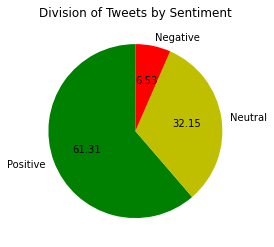

In [68]:
label_count = updated_dataset['Vader Sentiment'].value_counts()
plt.pie(label_count.values, labels=label_count.index, autopct= '%1.2f', colors= ['g', 'y', 'r'], startangle= 90)
plt.title("Division of Tweets by Sentiment")
plt.show()

As mentioned previously in the data labelling section, majority of the tweets are postive and neutral at 61.31% and 32.15% respectively with only ~6.53% negative tweets based on labelling with Vader.

Text(0.5, 1.0, 'Number of Tweets // Compound')

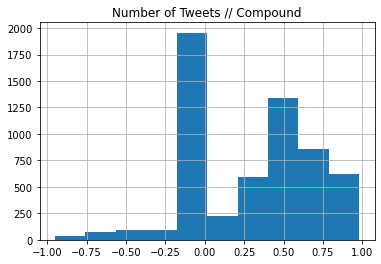

In [69]:
compound = []
for i in updated_dataset['Vader Analysis']:
    compound.append(i.get('compound'))

pd.Series(compound).hist()
plt.title('Number of Tweets // Compound')

This histogram shows the compound values assigned to the tweets using Vader sentiment. Following the norm, tweets with compound values more than 0.05 are marked as positive and tweets with values less than -0.05 are marked as negative, ones with the values in between are neutral. From the histogram, it's clear that most tweets have been assigned values more than ~ -0.15, showing us that more than 90% of the tweets and positive and neutral with very few negative. This imbalance in data is probably due to the lack of proper sentiment represented in the scrapped tweets, as most of the tweets are advertisements or bot spams which will be discussed on more in the below sections.

### Analysing Each Sentiment

#### Postive Tweets

##### Word Cloud for Positive Tweets

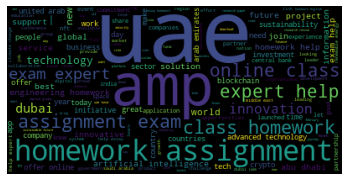

In [70]:
positive = updated_dataset[updated_dataset['Vader Sentiment']=='Positive']
positives = ' '.join(tweet for tweet in positive['Cleaned Text'])
wordcloud_pos = WordCloud().generate(positives)

plt.figure()
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.show()

##### Bar Chart showing most popular tokens for Positive Tweets

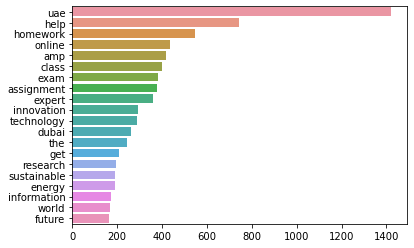

In [71]:
def plot_tokens(tweet):
    text = [word for i in tweet for word in i]

    n = Counter(text)
    common = n.most_common()
    amounts, tokens = [], []
    for token, amount in common[:20]:
            amounts.append(amount)
            tokens.append(token)
            
    sns.barplot(x = amounts, y = tokens)

plot_tokens(positive['Tokenized Text'])

##### Bar Chart showing most popular bigrams for Positive Tweets

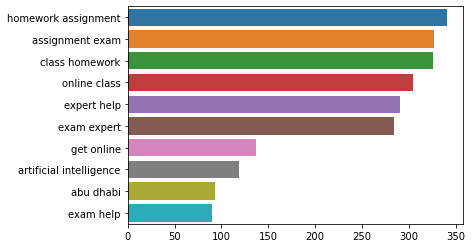

In [72]:
def getNgram(text, n):
        vec = CountVectorizer(ngram_range=(n, n)).fit(text)
        bow = vec.transform(text)
        sum = bow.sum(axis=0) 
        freq = [(t, sum[0, i]) for t, i in vec.vocabulary_.items()]
        freq = sorted(freq, key = lambda x: x[1], reverse=True)
        return freq[:10]

def plot_ngrams(tweet, n):
    topNgrams = getNgram(tweet, n)[:10]
    ngram, count = map(list,zip(*topNgrams))
    sns.barplot(x = count, y = ngram)

plot_ngrams(positive['Cleaned Text'], 2)

##### Bar Chart showing most popular trigrams for Positive Tweets

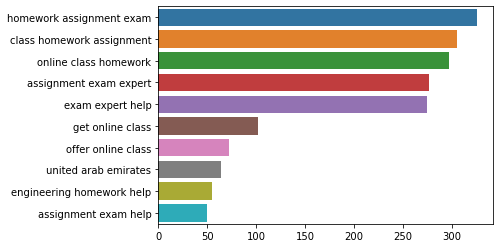

In [73]:
plot_ngrams(positive['Cleaned Text'], 3)

##### Printing random reviews with positive polarity

In [74]:
twt = updated_dataset['Text'].loc[updated_dataset['Encoded_Vader_Sentiment'] == 1].sample(10).values
for i in twt:
    print(i)

b'Irakli Garibashvili, Prime Minister - Georgia, during \na session at the @WorldGovSummit: The #UAE has always been at the forefront of innovation and progress \n#WorldGovSummit \n#WGS https://t.co/sHcL4p2ERP'
b'[1/2]\n2023 is the Year of Sustainability as declared by HH Sheikh Mohamed bin Zayed Al Nahyan, President of the United Arab Emirates, and we are giving back to the planet starting with our beaches. \n#UAE #Dubai #Sustainability https://t.co/UZaTF4iWO9'
b'Get online class homework, assignment and exam expert help with Mathematics, \n\nComputer Science\n\nElectrostatics\n\nGravitation\n\nMechanics\n\nModern Physics\n\nOptics\n\nAccounting \n\nFinance \n\nEconomics \n\nPhysics \n\nChemistry \n\nBiology\n\nSound and Waves\n\n#USA #Kuwait #UK #UAE #SaudiArabia'
b'Spring Semester is here, book your best tutors today for discounts on:\n1. Online class help\n2. Essay help\n3. Research paper help\n4. Exam help\n5. Dissertation \n\n #GramFam #Gramfam26 #ASUTwitter #ncat #ncat26 #wssu #

**Insights -**
After checking the world clouds, common tokens and trigrams, as well as printing 10 random high polarity tweets, we can see that most of the tweets labelled as positive are important news related to events held in the UAE as well as achievements in the field of technology. Subsequently, there are also many tweets where individuals are appreciating, acknowledging, and congratulating these events and achievements. The common bigrams and trigrams show repeated tokens "homework", "assignment", and "help" probably because of the excess number of tweets and spams promoting and advertising help for students with their homework with some using the keyword "expert" which can be viewed as a positive sentiment. Because of this, the tokens mentioned earlier could have also been labelled positive, resulting in these spams being marked as positive as well. 

#### Neutral Tweets

##### Word Cloud for Neutral Tweets

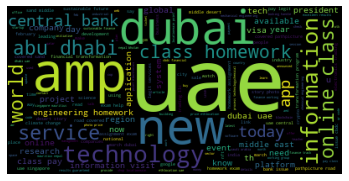

In [75]:
neutral = updated_dataset[updated_dataset['Vader Sentiment']=='Neutral']
neutrals = ' '.join(tweet for tweet in neutral['Cleaned Text'])
wordcloud_neu = WordCloud().generate(neutrals)

plt.figure()
plt.imshow(wordcloud_neu)
plt.axis('off')
plt.show()

##### Bar Chart showing most popular tokens for Neutral Tweets

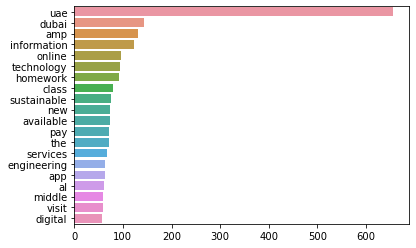

In [76]:
plot_tokens(neutral['Tokenized Text'])

##### Bar Chart showing most popular bigrams for Neutral Tweets

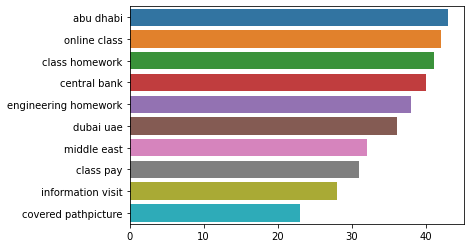

In [77]:
plot_ngrams(neutral['Cleaned Text'], 2)

##### Bar Chart showing most popular trigrams for Neutral Tweets

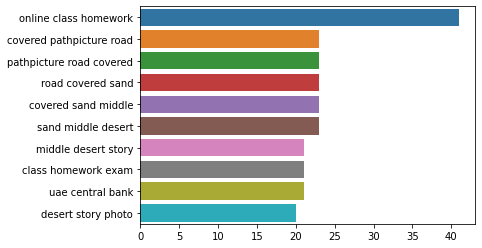

In [78]:
plot_ngrams(neutral['Cleaned Text'], 3)

##### Printing random reviews with most neutral polarity

In [79]:
twt = updated_dataset['Text'].loc[updated_dataset['Encoded_Vader_Sentiment'] == 0].sample(10).values
for i in twt:
    print(i)

b'Engage yourself with professional writers on your academic work. \nLiterature\nMathematics\nResearch papers\nDissertation\nThesis\nLiterature review\nPowerPoint\nBibliography\nReport\nDiscussion\nReplies\nEconomics\nBusiness law\nMusic\nSociology\nHISTORY\nNursing\n#kuwait\n#UAE\n#USA\n#Australia https://t.co/vV1YdSG3m0'
b'COVID-19 Research: Chinese Study Finds That SARS-CoV-2\xe2\x80\x99s Nsp15 Protein Suppresses Type I Interferon Production!\nhttps://t.co/GLXnQK9H9V\n#covid19research #COVID19 #Covid  #research #USA #news #America #California #Europe #London #UAE #healthcare #SARSCoV2 #virus #immunity #india'
b"Agora Group's 11th Global #Blockchain Conference is featured on #DSRPTDBlog\nRead the press release here: https://t.co/Jx2ggKQGwm\n\nand stay updated on all headlines on https://t.co/YjwY59Xogj\n\n#Startups #Investors #Dubai https://t.co/P6powsGhvg"
b'Use this link to access a wide range of our services anytime and from anywhere.\nhttps://t.co/Rua3RIQvcs\n#DigitalGovernment\n

**Insights -**
Just like the positive tweets, most of the tweets here are talking about events taking place in UAE with some addition of news around technologies, finances, and properties of UAE and other countries. Again, the tokens "homework", "class", and "exam" have also been repeately mentioned here because of bot spams. Most tweets with promotions and advertisements have been labelled as neutral, with companies promoting their items and services and also hiring employees. 

#### Negative Tweets

##### Word Cloud for Negative Tweets

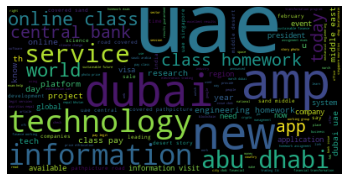

In [80]:
negative = updated_dataset[updated_dataset['Vader Sentiment']=='Negative']
negatives = ' '.join(tweet for tweet in negative['Cleaned Text'])
wordcloud_neg = WordCloud().generate(neutrals)

plt.figure()
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.show()

##### Bar Chart showing most popular tokens for Negative Tweets

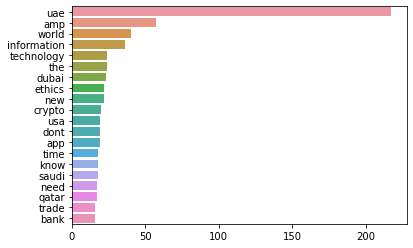

In [81]:
plot_tokens(negative['Tokenized Text'])

##### Bar Chart Showing most popular bigrams for Negative Tweets

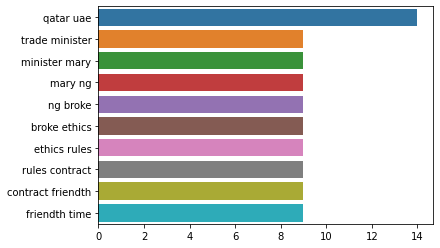

In [82]:
plot_ngrams(negative['Cleaned Text'], 2)

##### Bar Chart showing most popular trigrams for Negative Tweets

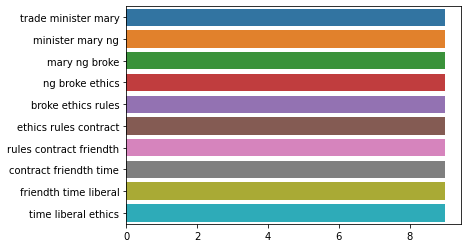

In [83]:
plot_ngrams(negative['Cleaned Text'], 3)

##### Printing random reviews with most possible negative polarity

In [84]:
twt = updated_dataset['Text'].loc[updated_dataset['Encoded_Vader_Sentiment'] == -1].sample(10).values
for i in twt:
    print(i)

b'@fighting4human1 @SRclimatechange How shameful of you to say that! What about the millions projects and initiatives undertaken by #UAE and @Masdar in more than 40+ countries for promoting renewable energy? No country in the world is taking up #ClimateChange as seriously as #UAE! \nStop this OIL bull-shit now!'
b"@giroditalia @uae_tour @lorenawiebes @teamsdworx \xf0\x9f\xa4\x94Forget everything you've ever seen in transmission technology!\xf0\x9f\x98\xb1\n\nWe are not robots. This project is real and disruptive. Visit our profile and follow us to know more about ESG Universal Transmission. Doubts? Comment, Inbox or fidgetstartech@gmail.com\n\xe2\x9a\xa1\xef\xb8\x8f\xf0\x9f\x94\xa5\xe2\x99\xbb\xef\xb8\x8f\xf0\x9f\x8c\x8e\xf0\x9f\x8c\x8d\xf0\x9f\x8c\x8f\xf0\x9f\xa6\xbe\xf0\x9f\x8f\x81"
b'RT @sabet: \xf0\x9f\x94\xa5TOKYO PUNKS | BAD BUNNIES by SABET\n#NFTGiveaway 100 Bad Bunnies on 2/28/23 Drop Day\n\xe2\x9c\x85 Follow: @sabet @tokyopunksnft @healingcod\xe2\x80\xa6'
b'One other Member of

**Insights -**
Surprisingly, the negative tweets have around no ads. These tweets have been divided into short fall backs and failures of the UAE, involvement of the UAE around catastrophes like covid-19, earthquakes, wars, etc., as well as individuals complaining about personal documents like visas and passports and about applications and websites. A few promotions and ads have slipped in, which have keywords surrounding negative sentiments like "low" and "lowest" (mostly hinting at low prices for goods). Overall, Vader did an excellent job labelled negative tweets.

# Conclusions

We've experimented with various text labelling, word representation and classification techniques and found this pipeline to be the best performing. 

1. **Data collection of tweets using the Twitter API**
2. **Data cleaning (Removing duplicates, links, hashtags and @s)**
    This was done before labelling to reduce tweets from getting labelled twice.
3. **Data labelling using TextBlob**
    We experimented with labelling using TextBlob and Vader, however, when reviewing tweets that had conflicting labels from TextBlob and Vader, we found Vader to be more accurate. 
    
    The tweets were validated by a manual review through the tweets that had conflicting labels. 
4. **Data preprocessing (Removing stop words, foreign words, symbols, numbers, tokenizing and lemmatizing)**
    We followed standard data preprocessing techniques for text analysis as well as other methods unique to this dataset (i.e removing 'b' and 'RT' from the text). 
    
    Between tokenizing and lemmatizing, lemmatizing was chosen as it had higher accuracy.
    
5. **Representing the text using 1 to 6 N-Grams**
    We experimented with various text representation methods (Bag of words, CBOW, Ngrams, Skipgrams, Word2Vec) and compared them by performance using a Naive Bayes classifier as a baseline reference. 
    
    After comparison of each of the representations, N-grams in the range (1,6) was found out to be the best performer in terms of the macro F1 score.

    This representation was then used for classification in the next step of the pipeline.
6. **Text classification using a Logistic Regression model**
    3 classification models were tested: Logistic Regression, Decision Trees and FastText supervised classifier as well as experimented with their hyperparameters. 
    
    Using weighted F1 average as our main metric, Decision Trees performed the best between the 3. The default parameters had the best performance. 

Data Collection -> Data Cleaning -> Data Labelling -> Data Preprocessing -> Word Representation using N-Grams(1,6) -> Decision Tree Classification

However, our dataset was very imbalanced. The classes were not equally represented, as very few samples of 'Negative' sentiment were found. This implies that the majority sentiment towards 'Tech & Innovation in the UAE' is Positive and Neutral.

Sentiment analysis has been used for various applications in marketing and NLP research. For this particular coursework, sentiment analysis of tweets about the UAE could be used for event planning and advertisements.

# Project Overview

The steps to analysing the sentiments on tweets relating to 'Tech and innpenistion in the UAE' are summarized as follows:

1. Data Collection.

    Tweets were scraped with the aid of the Tweepy python library. In order to verify that the scraped tweets were related to the UAE, each tweet either had to originate inside the UAE or the term 'uae' is explicitly in the tweet. Terms related to 'Technology and Innovation in UAE' were sourced by researching synonyms and related words of such 'technology' and 'innovation', as well as top IT companies in UAE (amazon, cisco, etc), and events related to IT in the UAE (COP28, GITEX, UAE hackathon, etc). Sources of such terms are found in [1], [2], [3], [4], and [5]

    Tweet queries were built following the twitter API docs [6], to ensure best practice of tweet formulation.

    Duplicate tweets were attempted to be removed to using specified keywords in the queries, however, some duplicates (i.e., retweets) were still recieved. Such duplicates were cleaned in the data labelling and text proccessing section.

     
2. Data Labelling

    Both TextBlob and Vader were used to label sentiments of tweets and each method was compared. According to [7] "Vader is more focused on social media, putting more effort in identifying sentiment of content typically appearing on social media, such as emojis, repetitive words, and puntuations". Therefore, we anticipated that Vader would be more accurate in labelling.

3. Text Processing

    Usual cleaning and preprocessing techniques for NLP were applied: removing stopwords, non-english characters, punctuations. etc. Duplicate tweets (i.e., retweets) were also removed. This was followed by tokenization, then lemmatization. We planned to compare their accuracy, and expected that lemmatization would perform better as this method is preferred over stemming for context analysis [8].  

4. Text Representation

    This section experimented with various text representation techniques: BOW, N-grams, TF-IDF, CBOW, Skip-gram, and a pre-trained Google Word2Vec model.
    Each of the representations were compared using the Naive Bayes classifier, as it has been observed to be the most common classifier amongst several sentiment analysis projects, and that NB is "known to work well for many text classification problems and requires relatively few training examples" [10].

    Each of the representations had different possible parameters (such as the ideal number for N-grams, best hyperparameters for the CBOW model, etc.), and they were experimented with.


4. Classification

    The classifiers used were logistic regression and decision trees which are common classifiers for sentiment analysis, and Fasttext, a classifier created by Facebook.

5. Evaluation

    Evaluation was performed thoughout, using precision and recall and the f1 score as the main metric. This is due to the class imbalance, where metrics such as accuracy or AUROC do not provide meaningful insights [11]. 

6. Visualisation
    
    Tweets and results are visualised using Matplotlib and Wordcloud, in order to gain insights on the results and tweets.

7. Conclusion
    
    Findings are documented in this section.

Sources:

[1] https://www.thesaurus.com/browse/technology <br>
[2] https://relatedwords.io/technology <br>
[3] https://www.gulftalent.com/it-companies-in-dubai <br>
[4] https://www.thesaurus.com/browse/technology <br>
[5] https://www.merriam-webster.com/thesaurus/innovation <br>
[6] https://docs.tweepy.org/en/stable/api.html#search-tweets <br>
[7] https://pub.towardsai.net/textblob-vs-vader-for-sentiment-analysis-using-python-76883d40f9ae <br>
[8] https://www.researchgate.net/publication/348306833_An_Interpretation_of_Lemmatization_and_Stemming_in_Natural_Language_Processing <br>
[10] https://www.aiperspectives.com/twitter-sentiment-analysis/ <br>
[11] https://glassboxmedicine.com/2019/03/02/measuring-performance-auprc/ <br>
